# Adjoint optimization of an waveguide bend using topology optimization

Here we'll give a demo of performing topology optimization of a 3D waveguide bend.

<!-- 
<img src="img/adjoint_9.png" width=400 alt="Schematic of the waveguide division multiplexer"> -->

To see the same problem performed with shape optimization, [this demo notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd8WaveguideBend/).

If you are unfamiliar with inverse design, we also recommend our [intro to inverse design tutorials](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and our [primer on automatic differentiation with tidy3d](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/).

> Note: to see to the simple, [high level definition](https://www.flexcompute.com/tidy3d/examples/notebooks/InverseDesign/) of the inverse desgin problem using `tidy3d.plugins.invdes`, jump to the 2nd to last cell!

In [1]:
import tidy3d as td
import tidy3d.web as web

import matplotlib.pylab as plt
import autograd
import autograd.numpy as np

In [2]:
wvl0 = 1.0

freq0 = td.C_0 / wvl0

eps_mat = 4.0
wg_width = 0.5 * wvl0
wg_length = 1.0 * wvl0
design_size = 3 * wvl0
thick = 0.2 * wvl0

pixel_size = wvl0/100

In [3]:
waveguide_in = td.Structure(
    geometry=td.Box(
        center=(-wg_length-design_size/2, 0, 0),
        size=(2 * wg_length, wg_width, thick),
    ),
    medium=td.Medium(permittivity=eps_mat),
)

waveguide_out = td.Structure(
    geometry=td.Box(
        center=(0, waveguide_in.geometry.center[0], 0),
        size=(wg_width, waveguide_in.geometry.size[0], thick),
    ),
    medium=td.Medium(permittivity=eps_mat),
)

design_region_geometry = td.Box(
    center=(0,0,0),
    size=(design_size, design_size, thick),
)

mode_source = td.ModeSource(
    center=(-design_size/2.0-wg_length+wvl0/3, 0, 0),
    size=(0, wg_width * 3, td.inf),
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=freq0/20,
    ),
    mode_index=0,
    direction="+"
)

mode_monitor = td.ModeMonitor(
    center=(0, mode_source.center[0], 0),
    size=(mode_source.size[1], 0, td.inf),
    freqs=[freq0],
    mode_spec=td.ModeSpec(num_modes=1),
    name='mode',
)

field_monitor = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name='field',
)

sim_base = td.Simulation(
    size=(2 * wg_length + design_size, 2 * wg_length + design_size, thick + 2 * wvl0),
    run_time=100/mode_source.source_time.fwidth,
    structures=[waveguide_in, waveguide_out],
    sources=[mode_source],
    monitors=[mode_monitor],
    boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=True),
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=20,
        override_structures=[
            td.MeshOverrideStructure(
                geometry=design_region_geometry,
                dl=3*[pixel_size]
            )
        ]
    )
)

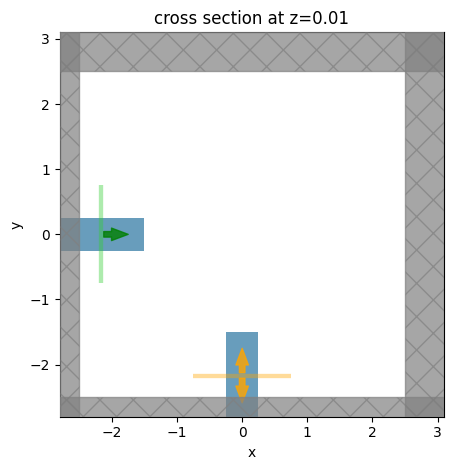

In [4]:
ax = sim_base.plot(z=0.01)
plt.show()

In [5]:
from tidy3d.plugins.autograd import make_filter_and_project, get_kernel_size_px

# radius of the circular filter (um) and the threshold strength
radius = 0.150
num_pixels_dim = int(design_size / pixel_size)

filter_size = get_kernel_size_px(radius, pixel_size)
filter_project_fn = make_filter_and_project(radius=radius, dl=pixel_size)

def get_density(params: np.ndarray, beta: float) -> np.ndarray:
    """Get the density of the material in the design region as function of optimization parameters."""
    return filter_project_fn(params, beta=beta)

def get_design_region(params: np.ndarray, beta: float) -> td.Structure:
    """Get design region structure as a function of optimization parameters."""
    density = get_density(params, beta=beta)
    eps_data = 1 + (eps_mat - 1) * density
    return td.Structure.from_permittivity_array(
        eps_data=eps_data,
        geometry=design_region_geometry
    )

def get_sim(params: np.ndarray, beta: float, with_fld_mnt: bool=False) -> td.Simulation:
    """Get simulation as a function of optimization parameters."""
    design_region = get_design_region(params, beta=beta)
    sim = sim_base.copy()
    if with_fld_mnt:
        sim = sim.updated_copy(monitors=sim_base.monitors + (field_monitor,))
    return sim.updated_copy(structures=sim_base.structures + (design_region,))


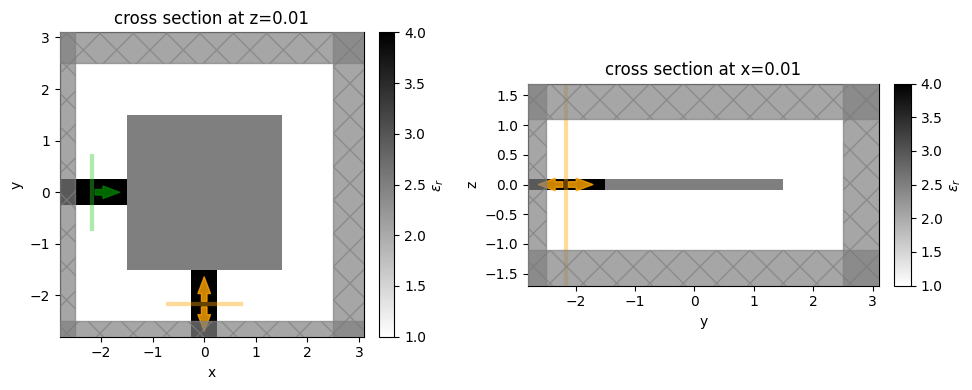

In [6]:
params0 = np.random.random((num_pixels_dim, num_pixels_dim, 1))
params0 = np.ones((num_pixels_dim, num_pixels_dim, 1)) * 0.5
sim0 = get_sim(params0, beta=50.0)

_, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, figsize=(10,4))
sim0.plot_eps(z=0.01, ax=ax1)
sim0.plot_eps(x=0.01, ax=ax2)
plt.show()

In [7]:
from tidy3d.plugins.autograd.invdes import make_erosion_dilation_penalty

def get_transmission(params: np.ndarray, beta: float) -> float:
    """Get transmission in output waveguide fundamental mode."""
    sim = get_sim(params, beta=beta)
    data = web.run(sim, task_name='bend', verbose=False)
    mode_amps = data['mode'].amps.sel(direction='-')    
    return np.sum(abs(mode_amps.values)**2)

penalty_fn = make_erosion_dilation_penalty(radius=radius, dl=pixel_size, beta=10.0)

def get_penalty(params: np.ndarray, beta: float) -> float:
    """Get penalty due to violation of fabrication constraints."""
    density = get_density(params, beta=beta)
    return penalty_fn(density)

def get_penalty_bin(params: np.ndarray, beta) -> float:
    density = get_density(params, beta=beta)
    error = (density) * (density - 1)
    return np.sum(error) / len(error)
    
def objective(params: np.ndarray, beta: float, only_penalty:bool=True) -> float:
    """Objective function."""
    penalty = get_penalty(params, beta=beta)    

    # if only_penalty:
    #     return - penalty #- get_penalty_bin(params, beta=beta)

    transmission = get_transmission(params, beta=beta)
    return transmission - penalty


In [8]:

val_grad = autograd.value_and_grad(objective)

16:46:02 EDT Created task 'inv_des_final' with task_id                          
             'fdve-74fd790a-146a-46e1-817d-fb075533d353' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=328875;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74fd790a-146a-46e1-817d-fb075533d353\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=256258;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74fd790a-146a-46e1-817d-fb075533d353\taskId]8;;\]8;id=328875;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74fd790a-146a-46e1-817d-fb075533d353\=]8;;\]8;id=134946;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74fd790a-146a-46e1-817d-fb075533d353\fdve]8;;\]8;id=328875;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74fd790a-146a-46e1-817d-fb075533d353\-74fd790a-146]8;;\
             ]8;id=328875;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74fd790a-146a-46e1-817d-fb075533d353\a-46e1-817d-fb075533d353']8;;\.

Output()

16:46:04 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

16:46:09 EDT status = preprocess

16:46:12 EDT Maximum FlexCredit cost: 1.509. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

16:46:34 EDT early shutoff detected at 4%, exiting.

             status = postprocess

Output()

16:46:41 EDT View simulation result at                                          
             ]8;id=801473;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74fd790a-146a-46e1-817d-fb075533d353\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=840729;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74fd790a-146a-46e1-817d-fb075533d353\taskId]8;;\]8;id=801473;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74fd790a-146a-46e1-817d-fb075533d353\=]8;;\]8;id=584228;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74fd790a-146a-46e1-817d-fb075533d353\fdve]8;;\]8;id=801473;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74fd790a-146a-46e1-817d-fb075533d353\-74fd790a-146]8;;\
             ]8;id=801473;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74fd790a-146a-46e1-817d-fb075533d353\a-46e1-817d-fb075533d353']8;;\.

Output()

16:46:42 EDT loading simulation from simulation_data.hdf5

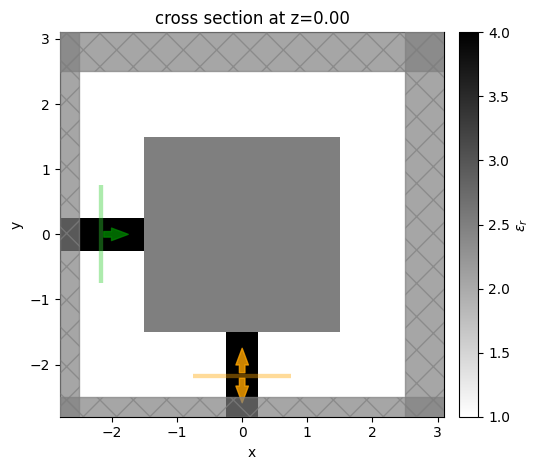

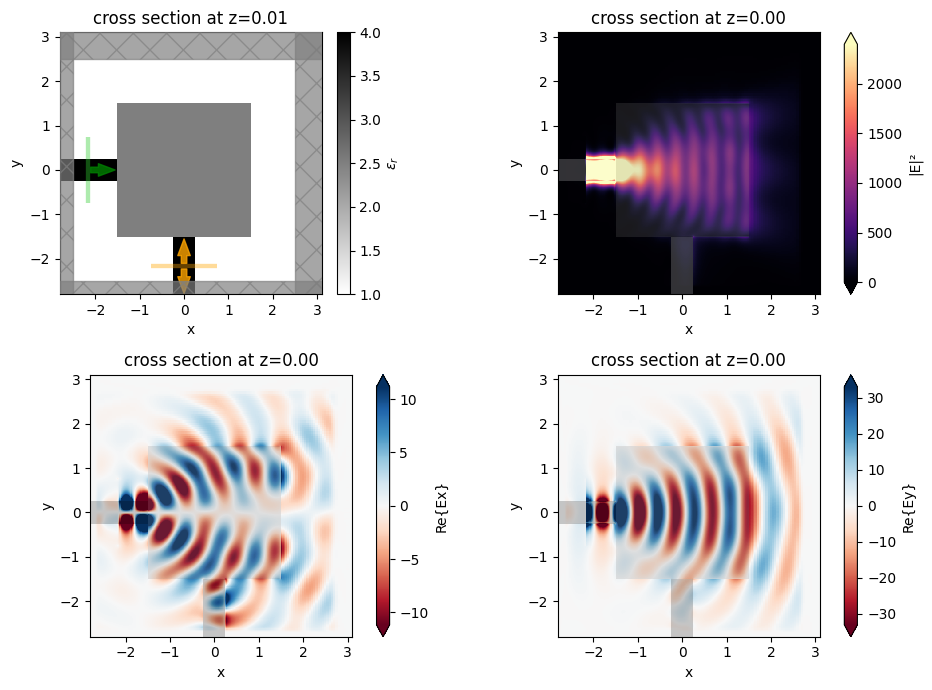

In [25]:
params_init = param_history[0]
sim_init = get_sim(params_init, beta=beta)
sim_init.plot_eps(z=0)

mode_monitor_init = mode_monitor.updated_copy(freqs=td.C_0 / np.linspace(wvl0 * 1.2, wvl0 / 1.2, 101))
sim_init = sim_init.updated_copy(monitors=(field_monitor, mode_monitor_final))
sim_data_init = web.run(sim_init, task_name="inv_des_final")

f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10, 7), tight_layout=True)
sim_init.plot_eps(z=0.01, ax=ax0)
ax1 = sim_data_init.plot_field("field", "E", "abs^2", z=0, ax=ax1)
ax2 = sim_data_init.plot_field("field", "Ex", z=0, ax=ax2)
ax3 = sim_data_init.plot_field("field", "Ey", z=0, ax=ax3)


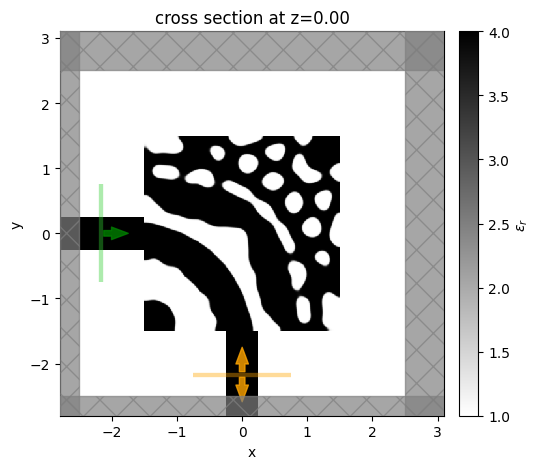

In [11]:
params_final = param_history[-1]
sim_final = get_sim(params_final, beta=beta)
sim_final.plot_eps(z=0)
plt.show()

step = 1
beta = 5.00


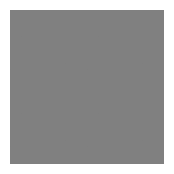

	J = -9.8928e-01
	grad_norm = 5.7425e-01
step = 2
beta = 5.62


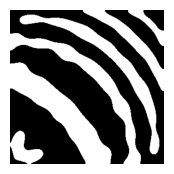

	J = -1.2953e-01
	grad_norm = 4.5661e-01
step = 3
beta = 6.25


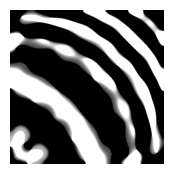

	J = -3.5540e-02
	grad_norm = 9.1560e-01
step = 4
beta = 6.88


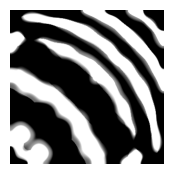

	J = 1.0567e-01
	grad_norm = 9.5809e-01
step = 5
beta = 7.50


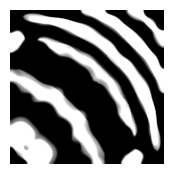

	J = 3.5399e-01
	grad_norm = 5.5354e-01
step = 6
beta = 8.12


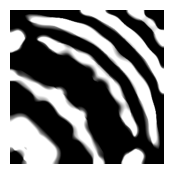

	J = 3.0937e-01
	grad_norm = 1.9766e+00
step = 7
beta = 8.75


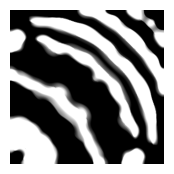

	J = 4.1059e-01
	grad_norm = 9.8066e-01
step = 8
beta = 9.38


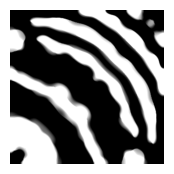

	J = 4.8377e-01
	grad_norm = 9.2449e-01
step = 9
beta = 10.00


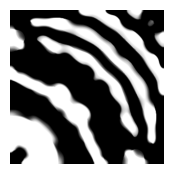

	J = 5.3324e-01
	grad_norm = 4.8341e-01
step = 10
beta = 10.62


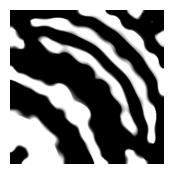

	J = 5.2825e-01
	grad_norm = 7.1760e-01
step = 11
beta = 11.25


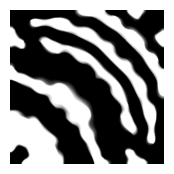

	J = 5.7922e-01
	grad_norm = 2.7559e-01
step = 12
beta = 11.88


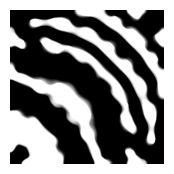

	J = 5.8533e-01
	grad_norm = 4.6194e-01
step = 13
beta = 12.50


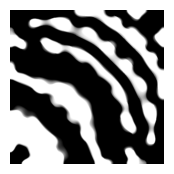

	J = 6.0561e-01
	grad_norm = 2.3820e-01
step = 14
beta = 13.12


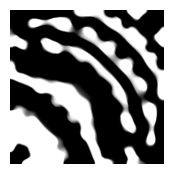

	J = 6.0512e-01
	grad_norm = 7.6677e-01
step = 15
beta = 13.75


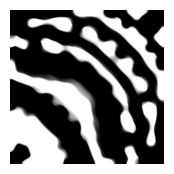

	J = 6.0775e-01
	grad_norm = 7.0891e-01
step = 16
beta = 14.38


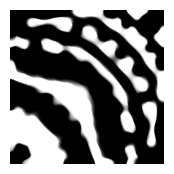

	J = 6.2763e-01
	grad_norm = 2.2145e-01
step = 17
beta = 15.00


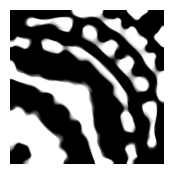

	J = 6.3243e-01
	grad_norm = 6.0495e-01
step = 18
beta = 15.62


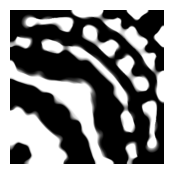

	J = 6.4358e-01
	grad_norm = 3.9763e-01
step = 19
beta = 16.25


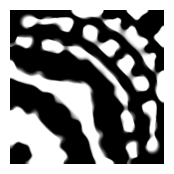

	J = 6.6121e-01
	grad_norm = 2.8635e-01
step = 20
beta = 16.88


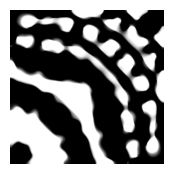

	J = 6.6914e-01
	grad_norm = 2.3813e+00
step = 21
beta = 17.50


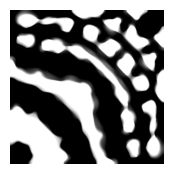

	J = 5.6197e-01
	grad_norm = 1.2830e+00
step = 22
beta = 18.12


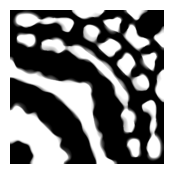

	J = 6.3616e-01
	grad_norm = 7.2391e-01
step = 23
beta = 18.75


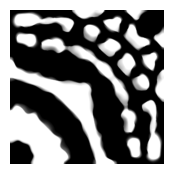

	J = 6.6053e-01
	grad_norm = 4.5606e-01
step = 24
beta = 19.38


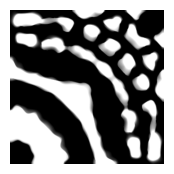

	J = 6.6701e-01
	grad_norm = 6.1148e-01
step = 25
beta = 20.00


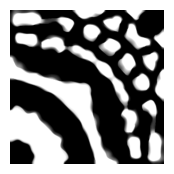

	J = 6.9513e-01
	grad_norm = 2.6409e-01
CPU times: user 2min 28s, sys: 27.7 s, total: 2min 56s
Wall time: 23min 38s


In [9]:
%%time
import optax

# hyperparameters
num_steps = 25
learning_rate = 1

# initialize adam optimizer with starting parameters
# params = np.random.random(params0.shape)
params = 0.5 * np.ones_like(params0)
# params = params0
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# beta as a function of step

beta_min = 5
beta_max = 20

def get_beta(step_num: int) -> float:
    """projection strength as a function of step number."""
    return beta_min + (beta_max - beta_min) * step_num / (num_steps - 1)

# store history
objective_history = []
param_history = [params]

for i in range(num_steps):

    print(f"step = {i + 1}")

    beta = get_beta(i)
    print(f"beta = {beta:.2f}")

    density = get_density(params, beta=beta)
    plt.subplots(figsize=(2,2))
    plt.imshow(np.flipud(1 - params.squeeze().T), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()
    
    # compute gradient and current objective funciton value
    value, gradient = val_grad(params, beta=beta)

    # outputs
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the optimizer based on gradient
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # it is important using optax to convert the parameters back to numpy arrays to feed back to our gradient
    params = np.array(params)
    params = np.clip(params, 0, 1)
    
    # save history
    objective_history.append(value)
    param_history.append(params)

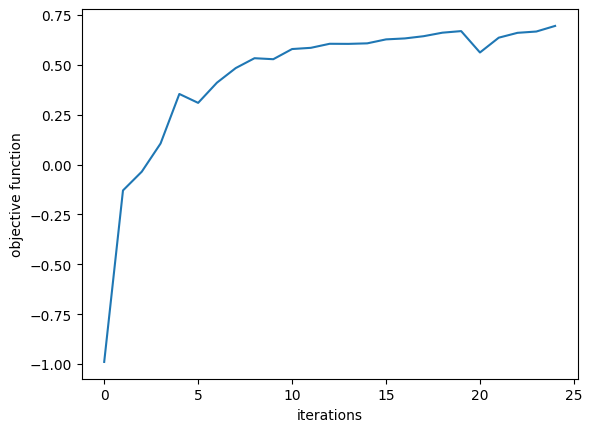

In [10]:
plt.plot(objective_history)
plt.xlabel("iterations")
plt.ylabel("objective function")
plt.show()

In [12]:
mode_monitor_final = mode_monitor.updated_copy(freqs=td.C_0 / np.linspace(wvl0 * 1.2, wvl0 / 1.2, 101))
sim_final = sim_final.updated_copy(monitors=(field_monitor, mode_monitor_final))
sim_data_final = web.run(sim_final, task_name="inv_des_final")

14:33:45 EDT Created task 'inv_des_final' with task_id                          
             'fdve-8efc3c98-4af9-49f3-a1be-148321510828' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=956954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8efc3c98-4af9-49f3-a1be-148321510828\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=280052;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8efc3c98-4af9-49f3-a1be-148321510828\taskId]8;;\]8;id=956954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8efc3c98-4af9-49f3-a1be-148321510828\=]8;;\]8;id=356020;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8efc3c98-4af9-49f3-a1be-148321510828\fdve]8;;\]8;id=956954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8efc3c98-4af9-49f3-a1be-148321510828\-8efc3c98-4af]8;;\
             ]8;id=956954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8efc3c98-4af9-49f3-a1be-148321510828\9-49f3-a1be-148321510828']8;;\.

Output()

14:33:48 EDT status = success

Output()

14:33:50 EDT loading simulation from simulation_data.hdf5

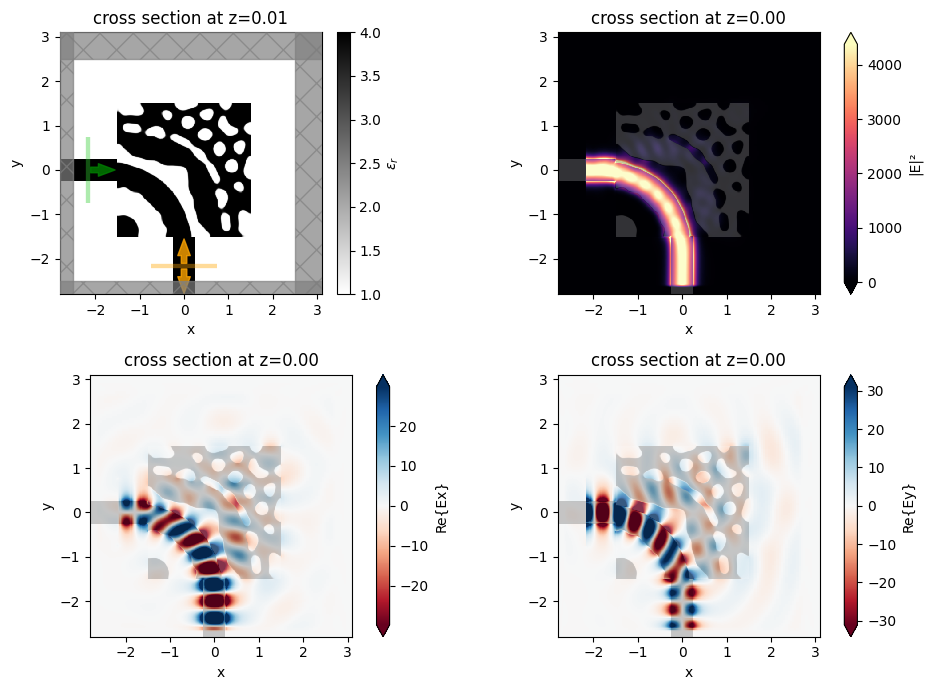

In [13]:
f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10, 7), tight_layout=True)
sim_final.plot_eps(z=0.01, ax=ax0)
ax1 = sim_data_final.plot_field("field", "E", "abs^2", z=0, ax=ax1)
ax2 = sim_data_final.plot_field("field", "Ex", z=0, ax=ax2)
ax3 = sim_data_final.plot_field("field", "Ey", z=0, ax=ax3)


Text(0, 0.5, 'transmission (dB)')

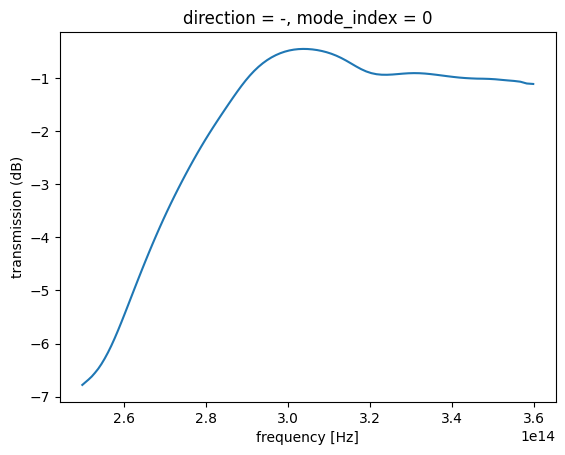

In [14]:
transmission = abs(sim_data_final['mode'].amps.sel(direction='-'))**2
transmission_db = 10 * np.log10(transmission)
transmission_db.plot(x='f')
plt.ylabel('transmission (dB)')
# plt.ylim(0,1)

In [15]:
sim_final.to_gds_file(
    fname="./misc/invdes_bend.gds",
    z=0,
    frequency=freq0,
    permittivity_threshold=(eps_mat + 1) / 2.0
)

## Using Inverse Design Plugin

Tidy3D now supports a higher level syntax for defining inverse design problems in a simpler way.

Here we'll show how to set up this same problem using that tool and run it for 2 iterations.

For a full tutorial, refer to [this example](https://docs.simulation.cloud/projects/tidy3d/en/latest/notebooks/InverseDesign.html).

In [18]:
import tidy3d.plugins.invdes as tdi
from tidy3d.plugins.expressions import ModePower

design_region = tdi.TopologyDesignRegion(
    size=design_region_geometry.size,
    center=design_region_geometry.center,
    eps_bounds=(1.0, eps_mat),
    pixel_size=pixel_size,
    transformations=[tdi.FilterProject(radius=radius, beta=beta_max)],
    penalties=[tdi.ErosionDilationPenalty(length_scale=radius)]
)

objective_function = ModePower(
    monitor_name="mode",
    direction='-', freqs=[freq0])

design = tdi.InverseDesign(
    simulation=sim_base,
    design_region=design_region,
    task_name="invdes",
    metric=objective_function,
)

optimizer = tdi.AdamOptimizer(
    design=design,
    num_steps=10,
    learning_rate=0.1,
)

# make True to run the optimizer for the number of steps defined above
run_optimizer = True

if run_optimizer:
    
    result = optimizer.run()
    result.plot_optimization()

In [19]:
# make true to generate frames for a gif in `out/`

make_gif = False

if make_gif:
    for i, param in enumerate(param_history):
        beta = get_beta(i)
        density = get_density(param, beta)
        plt.subplots(figsize=(2,2))
        plt.imshow(np.flipud(1 - density.squeeze().T), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        plt.savefig(f'out/{str(i).zfill(2)}.png')
        plt.close()